## Load dependencies

In [1]:
# --- standard ---
import os
import sys
import time
from datetime import datetime
from pathlib import Path

# --- scientific ---
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize, LightSource
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import ndimage
from scipy.interpolate import RBFInterpolator
from scipy.spatial import cKDTree

# --- machine learning / preprocessing ---
from sklearn.preprocessing import QuantileTransformer
from sklearn.cluster import KMeans, AgglomerativeClustering

# --- geostatistics ---
import skgstat as skg
from skgstat import models
import gstatsim as gs

# --- image / geometry utilities ---
from skimage.measure import find_contours

# --- parallelization ---
from joblib import Parallel, delayed

# --- local utilities (custom colormap) ---
from multigrid_sgsim.utils import geosoft_cmap_k65
geosoft_cmap = geosoft_cmap_k65()
ls = LightSource(azdeg=120, altdeg=45)

# --- local multigrid SGSIM implementation ---
from multigrid_sgsim import mgsim, sampling, trendmaking
from multigrid_sgsim.utils import cluster_variogram


## Load and plot synthetic data

In [2]:
## LOAD SYNTHETIC GROUND TRUTH GRID AND FLIGHTLINES ##
## ================================================ ##

# GROUND TRUTH
df_gt_xyvc = pd.read_csv("./data/gt_xyvc.csv")
gt_xyvc = df_gt_xyvc.values

# FLIGHT LINES
df_fl_xyvc = pd.read_csv("./data/fl_xyvc.csv")
fl_xyvc = df_fl_xyvc.values

# get number of subregions (clusters) from gt_xyvc
regions = gt_xyvc[:, 3]
unique_regions = np.unique(regions)
n_regions = len(unique_regions)
# set plot characteristics based on region clustering from gt_xyvc
cmap = plt.colormaps["tab20"].resampled(n_regions)
norm = mcolors.BoundaryNorm(
    boundaries=np.arange(-0.5, n_regions+0.5, 1),
    ncolors=n_regions
)


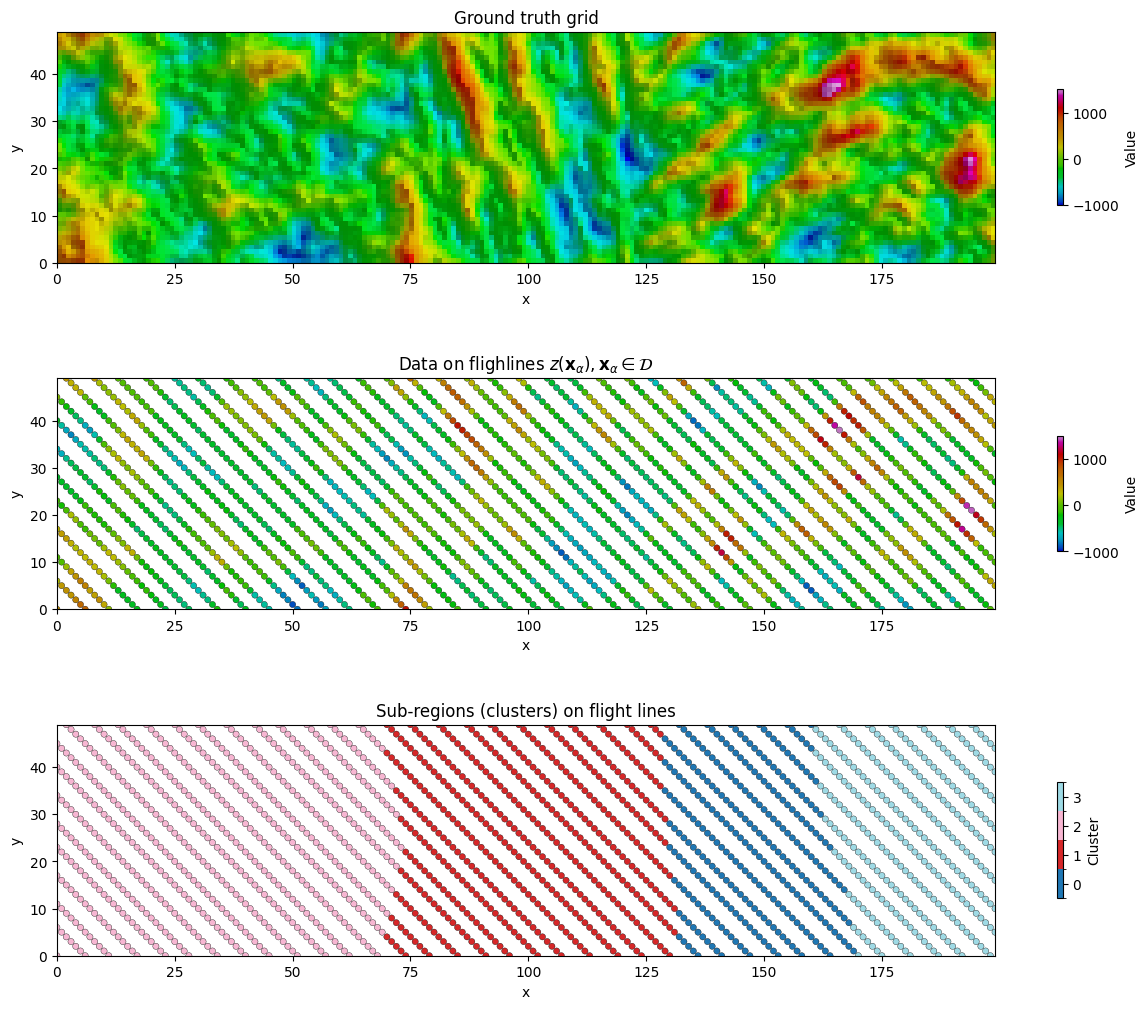

In [3]:
## PLOT GROUND TRUTH GRID AND FLIGHTLINES ##
## ====================================== ##

# color scale limits:
vmin, vmax = -1000, 1500
norm = Normalize(vmin=vmin, vmax=vmax)

# get grid dimensions:
x_unique = np.unique(gt_xyvc[:,0]); x_unique.sort()
y_unique = np.unique(gt_xyvc[:,1]); y_unique.sort()
nx, ny   = len(x_unique), len(y_unique)

# reshape to 2D grid:
gt_val_grid = gt_xyvc[:,2].reshape(ny, nx)

# light-shading:
gt_rgb = ls.shade(gt_val_grid, cmap=geosoft_cmap,blend_mode='soft', vmin=vmin, vmax=vmax)
extent = [x_unique.min(), x_unique.max(), y_unique.min(), y_unique.max()]

# cluster colormap setup ---
regions = gt_xyvc[:, 3]
unique_regions = np.unique(regions)
n_regions = len(unique_regions)
cmap_disc = plt.colormaps["tab20"].resampled(n_regions)
norm_disc = mpl.colors.BoundaryNorm(boundaries=np.arange(-0.5, n_regions + 0.5, 1),ncolors=n_regions)

# -- plots:
fig, axes = plt.subplots(3, 1, figsize=(16, 12))
plt.subplots_adjust(hspace=0.5)

# ground truth grid:
axes[0].imshow(gt_rgb, origin='lower', extent=extent, interpolation='nearest')
axes[0].set_title(r'Ground truth grid')
axes[0].set_xlabel("x"); axes[0].set_ylabel("y")
sm = plt.cm.ScalarMappable(norm=norm, cmap=geosoft_cmap)
sm.set_array([])
fig.colorbar(sm, ax=axes[0], shrink=0.5, label='Value')

# flight line data:
fl_x, fl_y, fl_val = fl_xyvc[:, 0], fl_xyvc[:, 1], fl_xyvc[:, 2]
sc = axes[1].scatter(fl_x, fl_y,c=fl_val, cmap=geosoft_cmap, norm=norm,s=20, edgecolors='k', linewidths=0.25,rasterized=True)
axes[1].set_title(r'Data on flighlines $z(\mathbf{x}_\alpha), \mathbf{x}_\alpha\in\mathcal{D}$')
axes[1].set_xlabel("x"); axes[1].set_ylabel("y")
axes[1].set_aspect('equal', adjustable='box')
axes[1].set_xlim(extent[0], extent[1]); axes[1].set_ylim(extent[2], extent[3])
sm = plt.cm.ScalarMappable(norm=norm, cmap=geosoft_cmap)
sm.set_array([])
fig.colorbar(sm, ax=axes[1], shrink=0.5, label='Value')

# sub-region (clusters):
sc2 = axes[2].scatter(fl_xyvc[:, 0], fl_xyvc[:, 1],c=fl_xyvc[:, 3],cmap=cmap_disc, norm=norm_disc,s=20, edgecolors='k', linewidths=0.25, rasterized=True)
axes[2].set_title("Sub-regions (clusters) on flight lines")
axes[2].set_xlabel("x"); axes[2].set_ylabel("y")
axes[2].set_aspect('equal', adjustable='box')
axes[2].set_xlim(extent[0], extent[1]); axes[2].set_ylim(extent[2], extent[3])
cb2 = fig.colorbar(sc2, ax=axes[2], shrink=0.5, ticks=np.arange(n_regions), label="Cluster")
cb2.ax.set_yticklabels([f"{int(r)}" for r in unique_regions])

plt.show()


## Make trend

In [4]:
## USE make_trend() TO MAKE A TREND ##
## ================================ ##

# define the grid and fl_xyvc
grid_xyc = np.column_stack([gt_xyvc[:, :2], gt_xyvc[:, 3]]) # isolate just the grid points and cluster id columns (get rid of values column)
fl_xyvc = fl_xyvc

# make the trend (note: this will be different trend each time the function is called, due to stochasticity in stratified sampling in the make_trend() function)
smoothing = 1.0
linespacing = 5
fl_xyvct, grid_xyct = trendmaking.make_trend(fl_xyvc, grid_xyc, smoothing, linespacing)



In [5]:
## COMPUTE RESIDUALS (only defined on flightlines) ##
## =============================================== ##

fl_resid   = fl_val - fl_xyvct[:,4]

# add residuals as new column of flightline array
fl_xyvctr = np.column_stack([fl_xyvct, fl_resid])


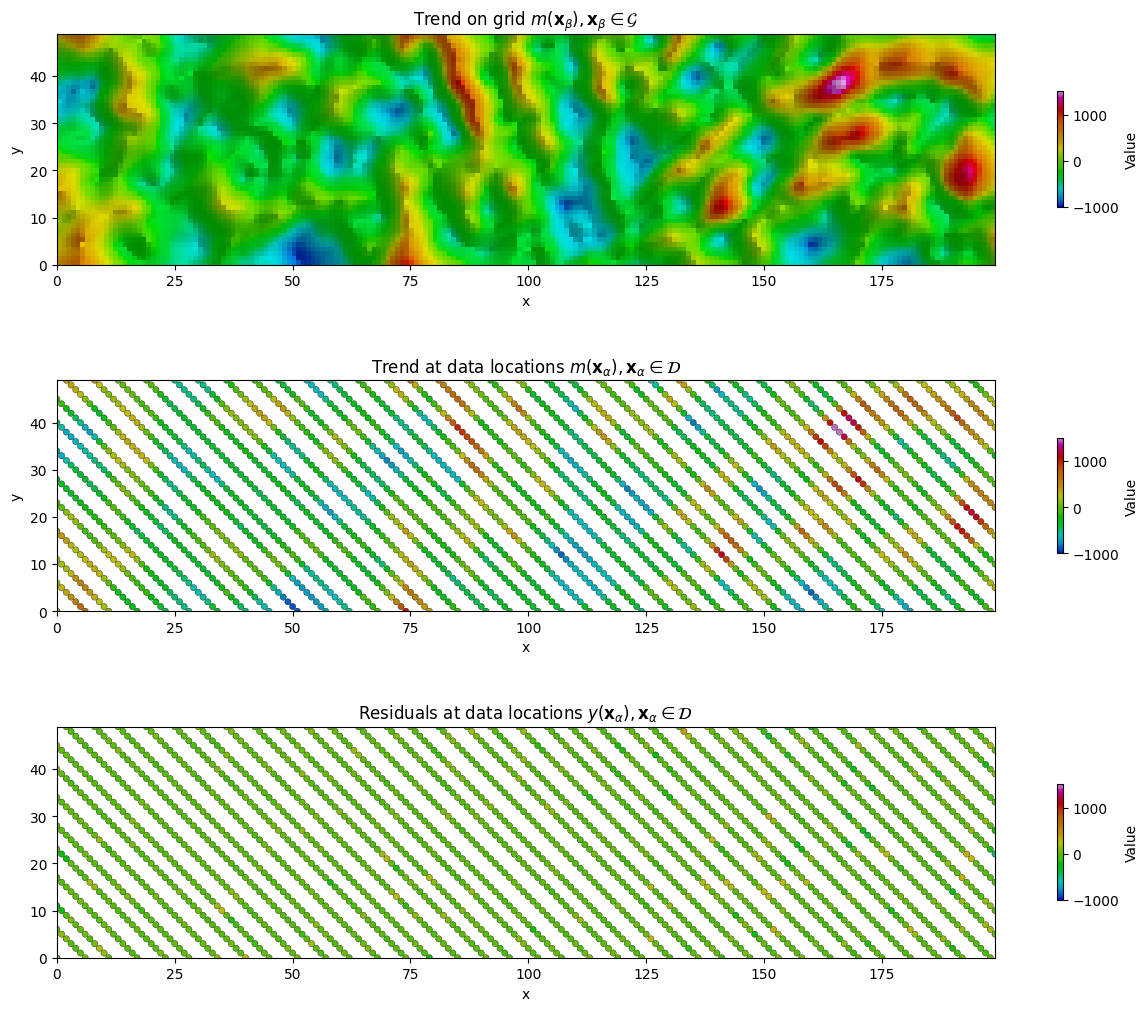

In [6]:
## PLOT TREND ##
## ========== ##

# color scale limits:
vmin, vmax = -1000, 1500
norm = Normalize(vmin=vmin, vmax=vmax)

# get grid dimensions:
x_unique = np.unique(grid_xyct[:,0]); x_unique.sort()
y_unique = np.unique(grid_xyct[:,1]); y_unique.sort()
nx, ny   = len(x_unique), len(y_unique)

# reshape to 2D grid:
trnd_val_grid = grid_xyct[:,3].reshape(ny, nx)

# light-shading:
trnd_rgb = ls.shade(trnd_val_grid, cmap=geosoft_cmap,blend_mode='soft', vmin=vmin, vmax=vmax)
extent = [x_unique.min(), x_unique.max(), y_unique.min(), y_unique.max()]

# -- plots:
fig, axes = plt.subplots(3, 1, figsize=(16, 12))
plt.subplots_adjust(hspace=0.5)

# trend on grid:
axes[0].imshow(trnd_rgb, origin='lower', extent=extent, interpolation='nearest')
axes[0].set_title(r'Trend on grid $m(\mathbf{x}_\beta), \mathbf{x}_\beta\in\mathcal{G}$')
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")
sm = plt.cm.ScalarMappable(norm=norm, cmap=geosoft_cmap)
sm.set_array([])
fig.colorbar(sm, ax=axes[0], shrink=0.5, label='Value')

# trend on flight line locations:
fl_x, fl_y, fl_trnd = fl_xyvc[:, 0], fl_xyvc[:, 1], fl_xyvct[:, 4]
sc = axes[1].scatter(fl_x, fl_y,c=fl_trnd, cmap=geosoft_cmap, norm=norm,s=20, edgecolors='k', linewidths=0.25,rasterized=True)
axes[1].set_title(r'Trend at data locations $m(\mathbf{x}_\alpha), \mathbf{x}_\alpha\in\mathcal{D}$')
axes[1].set_xlabel("x"); axes[1].set_ylabel("y")
axes[1].set_aspect('equal', adjustable='box')
axes[1].set_xlim(extent[0], extent[1])
axes[1].set_ylim(extent[2], extent[3])
sm = plt.cm.ScalarMappable(norm=norm, cmap=geosoft_cmap)
sm.set_array([])
fig.colorbar(sm, ax=axes[1], shrink=0.5, label='Value')

# residuals on flight line locations:
sc = axes[2].scatter(fl_x, fl_y,c=fl_resid, cmap=geosoft_cmap, norm=norm,s=20, edgecolors='k', linewidths=0.25,rasterized=True)
axes[2].set_title(r'Residuals at data locations $y(\mathbf{x}_\alpha), \mathbf{x}_\alpha\in\mathcal{D}$')
axes[2].set_xlabel("x"); axes[1].set_ylabel("y")
axes[2].set_aspect('equal', adjustable='box')
axes[2].set_xlim(extent[0], extent[1])
axes[2].set_ylim(extent[2], extent[3])
sm = plt.cm.ScalarMappable(norm=norm, cmap=geosoft_cmap)
sm.set_array([])
fig.colorbar(sm, ax=axes[2], shrink=0.5, label='Value')



## Create DataFrame for flightline information

In [7]:
## PACK FLIGHTLINE INFO AND GRID INFO INTO ##
##  DATAFRAMES FOR GStatSim COMPATIBILITY  ##
## ======================================= ##

df_fl_xyvctr = pd.DataFrame(
    fl_xyvctr,
    columns=["x", "y", "value", "cluster", "trend", "residual"]
)

df_grid_xyct = pd.DataFrame(
    grid_xyct,
    columns=["x", "y", "cluster", "trend"]
)

print("flightline DataFrame")
print(df_fl_xyvctr.head())
print("\ngrid DataFrame")
print(df_grid_xyct.head())


flightline DataFrame
      x    y       value  cluster       trend   residual
0   0.0  0.0  474.224075      2.0  475.366975  -1.142900
1   6.0  0.0  749.593665      2.0  668.872315  80.721350
2  11.0  0.0  131.113667      2.0  128.218580   2.895087
3  17.0  0.0 -270.998116      2.0 -245.800196 -25.197920
4  23.0  0.0 -432.319171      2.0 -427.797217  -4.521954

grid DataFrame
     x    y  cluster       trend
0  0.0  0.0      0.0  475.366975
1  1.0  0.0      0.0  519.811702
2  2.0  0.0      0.0  574.410697
3  3.0  0.0      0.0  634.641447
4  4.0  0.0      0.0  688.154929


In [8]:
## AUGMENT DATAFRAME TO INCLUDE OBSERVATION POINT SET INFORMATION ##
## ============================================================== ##

# config
xcol, ycol, vcol = "x", "y", "value"
tol = 1e-8

# build KDTree to map flightline points -> grid nodes
grid_xy = df_grid_xyct[[xcol, ycol]].to_numpy()
obs_xy  = df_fl_xyvctr[[xcol, ycol]].to_numpy()
obs_val = df_fl_xyvctr[vcol].to_numpy()

tree = cKDTree(grid_xy)
dist, gi = tree.query(obs_xy, distance_upper_bound=tol)  # gi==len(grid_xy) if no match
valid = np.isfinite(dist) & (gi >= 0) & (gi < len(grid_xy))

# start from grid; create df_xyvtcs with desired columns and dtypes
df_xyvtcs = df_grid_xyct.copy()
df_xyvtcs["set"] = np.zeros(len(df_xyvtcs), dtype=np.int8)

# initialize non-observation points as NaN
df_xyvtcs[vcol] = np.nan

# handle duplicates
matched = pd.DataFrame({"grid_idx": gi[valid].astype(int), vcol: obs_val[valid]})
agg = matched.groupby("grid_idx", as_index=False)[vcol].mean()

# assign values and flags
df_xyvtcs.loc[agg["grid_idx"].values, vcol] = agg[vcol].values
df_xyvtcs.loc[agg["grid_idx"].values, "set"] = 1

# reorder columns: x, y, value, trend, cluster, set
first = [xcol, ycol, vcol, "trend", "cluster", "set"]
rest = [c for c in df_xyvtcs.columns if c not in first]
df_xyvtcs = df_xyvtcs.loc[:, first + rest]

# print statements
print(f"Obs points total: {len(obs_xy)}")
print(f"Matched to grid within tol: {valid.sum()}")
print(f"Grid nodes updated (deduped): {len(agg)}")
print(f"Unmatched obs: {len(obs_xy) - valid.sum()}")

df_xyvtcs


Obs points total: 1767
Matched to grid within tol: 1767
Grid nodes updated (deduped): 1767
Unmatched obs: 0


,x,y,value,trend,cluster,set
0,0.0,0.0,474.224075,475.366975,0.0,1
1,1.0,0.0,NaN,519.811702,0.0,0
2,2.0,0.0,NaN,574.410697,0.0,0
3,3.0,0.0,NaN,634.641447,0.0,0
4,4.0,0.0,NaN,688.154929,0.0,0
...,...,...,...,...,...,...
9995,195.0,49.0,NaN,-279.980455,2.0,0
9996,196.0,49.0,NaN,-321.628883,2.0,0
9997,197.0,49.0,NaN,-340.488442,2.0,0
9998,198.0,49.0,NaN,-344.117137,2.0,0


In [14]:
df_singlecluster = df_xyvtcs.copy()
df_singlecluster["cluster"] = 0
df_singlecluster

,x,y,value,trend,cluster,set
0,0.0,0.0,474.224075,475.366975,0,1
1,1.0,0.0,NaN,519.811702,0,0
2,2.0,0.0,NaN,574.410697,0,0
3,3.0,0.0,NaN,634.641447,0,0
4,4.0,0.0,NaN,688.154929,0,0
...,...,...,...,...,...,...
9995,195.0,49.0,NaN,-279.980455,0,0
9996,196.0,49.0,NaN,-321.628883,0,0
9997,197.0,49.0,NaN,-340.488442,0,0
9998,198.0,49.0,NaN,-344.117137,0,0


## Define variogram per cluster

In [15]:
## BUILD CLUSTER-SPECIFIC THEORETICAL VARIOGRAMS ##
## ============================================= ##

# set max lag and number of lags
maxlag = 40
n_lags = 40

# compute cluster-specific variograms for each region
# NOTE: V0.parameters is [range, sill, nugget]
value_or_residual = 'residual'
V0 = cluster_variogram(df_fl_xyvctr, value_or_residual, 0, maxlag, n_lags)
V1 = cluster_variogram(df_fl_xyvctr, value_or_residual, 1, maxlag, n_lags)
V2 = cluster_variogram(df_fl_xyvctr, value_or_residual, 2, maxlag, n_lags)
V3 = cluster_variogram(df_fl_xyvctr, value_or_residual, 3, maxlag, n_lags)


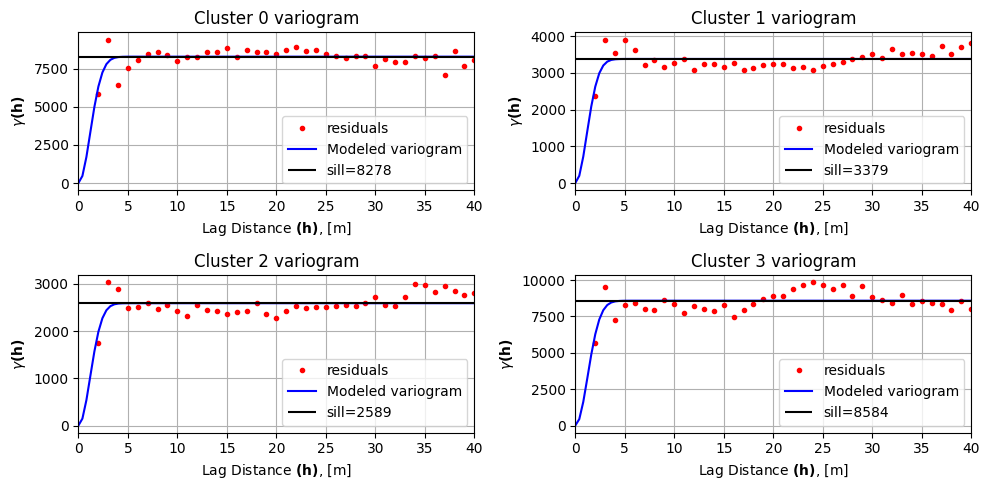

In [10]:
## PLOT CLUSTER-SPECIFIC VARIOGRAMS ##
## ================================ ##

# FIT THEORETICAL VARIOGRAMS

# model used in fit
vtype = 'gaussian'
V0.model = vtype
V1.model = vtype
V2.model = vtype
V3.model = vtype 

# create array of evenly spaced lag values to evaluate
n = 100
lagh = np.linspace(0,40,n)

range0 = V0.parameters[0]; sill0 = V0.parameters[1]; nug0 = V0.parameters[2]
range1 = V1.parameters[0]; sill1 = V1.parameters[1]; nug1 = V1.parameters[2]
range2 = V2.parameters[0]; sill2 = V2.parameters[1]; nug2 = V2.parameters[2]
range3 = V3.parameters[0]; sill3 = V3.parameters[1]; nug3 = V3.parameters[2]

y0 = [models.gaussian(h, range0, sill0, nug0) for h in lagh]
y1 = [models.gaussian(h, range1, sill1, nug1) for h in lagh]
y2 = [models.gaussian(h, range2, sill2, nug2) for h in lagh]
y3 = [models.gaussian(h, range3, sill3, nug3) for h in lagh]

variograms = [V0, V1, V2, V3]
ys = [y0, y1, y2, y3]

# PLOT (2x2 layout)
fig, axs = plt.subplots(2, 2, figsize=(10, 5))  # 2x2 grid
axs = axs.flatten()  # flatten to 1D for iteration

for i, (ax, V, y) in enumerate(zip(axs, variograms, ys)):
    ax.plot(V.bins, V.experimental, '.', color='red', label='residuals')
    ax.plot(lagh, y, '-', color='blue', label='Modeled variogram')
    ax.hlines(y=V.parameters[1], xmin=0, xmax=40,
              color='black', label=f"sill={V.parameters[1]:.0f}")
    ax.set_xlabel(r'Lag Distance $\bf(h)$, [m]')
    ax.set_ylabel(r'$\gamma \bf(h)$')
    ax.set_title(f'Cluster {i} variogram')
    ax.legend(loc='lower right')
    ax.set_xlim([0, 40])
    ax.grid(True)

plt.tight_layout()

plt.show()

In [ ]:
## CREATE VARIOGRAM DATAFRAME ##
## ========================== ##

azimuth = 0
# NOTE: gam = [azimuth, nugget, major_range, minor_range, sill, variogram_type]
gam0 = [azimuth, nug0, range0, range0, sill0, vtype]
gam1 = [azimuth, nug1, range1, range1, sill1, vtype]
gam2 = [azimuth, nug2, range2, range2, sill2, vtype]
gam3 = [azimuth, nug3, range3, range3, sill3, vtype]

df_gamma = pd.DataFrame({'Variogram': [gam0, gam1, gam2, gam3]})
df_gamma



,Variogram
0,"[0, 0, 3.362564313903251, 3.362564313903251, 8..."


## Try SGSIM

In [ ]:
# define coordinate grid
xmin = np.min(df_grid['X']); xmax = np.max(df_grid['X'])     # min and max x values
ymin = np.min(df_grid['Y']); ymax = np.max(df_grid['Y'])     # min and max y values

Pred_grid_xy = gs.Gridding.prediction_grid(xmin, xmax, ymin, ymax, res)

k = 100            # number of neighboring data points used to estimate a given point 
rad = 50000        # 50 km search radius

sgs = gs.Interpolation.cluster_sgs(Pred_grid_xy, df_grid, 'X', 'Y', 'Nbed', 'K', k, df_gamma, rad, seed=rng) 

## Run MGSIM

In [19]:
## GENERATE ONE REALIZATION WITH MGSIM ##
## =================================== ##

mg_resols = [20,10,5,4,3,2,1]  # note: spacing is in grid units (pixels) for this demo
df_grid = df_xyvtcs
df_mgsim = mgsim(mg_resols, df_grid, df_gamma, xx='x', yy='y', zz='residual', kk='cluster', num_points=10, radius=40)


MultiGrid iteration 1: Processing resolution 20


100%|██████████| 10000/10000 [00:35<00:00, 281.45it/s]


MultiGrid iteration 2: Processing resolution 10


100%|██████████| 10000/10000 [00:43<00:00, 231.59it/s]


MultiGrid iteration 3: Processing resolution 5


100%|██████████| 10000/10000 [00:34<00:00, 292.49it/s]


MultiGrid iteration 4: Processing resolution 4


100%|██████████| 10000/10000 [00:34<00:00, 292.67it/s]


MultiGrid iteration 5: Processing resolution 3


100%|██████████| 10000/10000 [00:30<00:00, 324.29it/s]


MultiGrid iteration 6: Processing resolution 2


100%|██████████| 10000/10000 [00:28<00:00, 350.47it/s]


MultiGrid iteration 7: Processing resolution 1


100%|██████████| 10000/10000 [00:29<00:00, 340.04it/s]


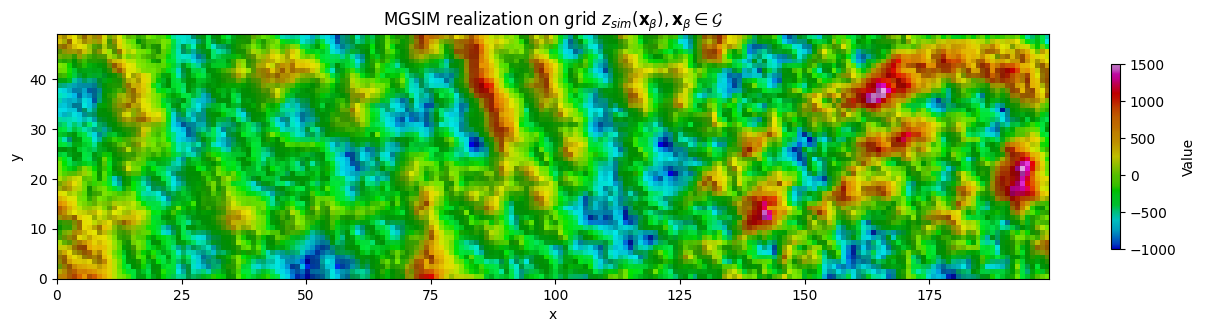

In [22]:
## PLOT MGSIM REALIZATION ##
## ====================== ##

# color scale limits:
vmin, vmax = -1000, 1500
norm = Normalize(vmin=vmin, vmax=vmax)

# get grid dimensions:
x_coords = df_mgsim['x'].values
y_coords = df_mgsim['y'].values
x_unique = np.unique(x_coords)
y_unique = np.unique(y_coords)
nx, ny   = len(x_unique), len(y_unique)

# values of mgsim realization:
values = df_mgsim['newtrend'].values

# reshape to 2D grid:
mgsim_realization = values.reshape(ny, nx)

# light-shading:
mgreal_rgb = ls.shade(mgsim_realization, cmap=geosoft_cmap,
                      blend_mode='soft', vmin=vmin, vmax=vmax)
extent = [x_unique.min(), x_unique.max(), y_unique.min(), y_unique.max()]

# plot
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.imshow(mgreal_rgb, origin='lower', extent=extent, interpolation='nearest')
ax.set_title(r'MGSIM realization on grid $z_{sim}(\mathbf{x}_\beta), \mathbf{x}_\beta\in\mathcal{G}$')
ax.set_xlabel("x"); ax.set_ylabel("y")
sm = plt.cm.ScalarMappable(norm=norm, cmap=geosoft_cmap)
sm.set_array([])
fig.colorbar(sm, ax=ax, shrink=0.3, label='Value')
